In [1]:
# using Plots
using LinearAlgebra

include("../smear_fem/src/fem.jl")
include("../smear_fem/src/PostProcess.jl")

Main.PostProcess

In [2]:
# test case 
# test case 
x0 = 0
x1 = 1
y0 = 0
y1 = 1
z0 = 0
z1 = 1
ne = 10
ndim = 3
FunctionClass = "Q2";

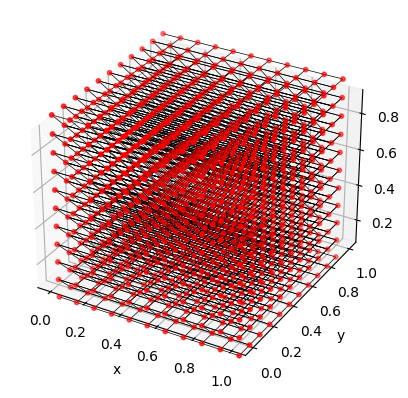

In [3]:
# set up mesh grid
function meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim)

    NodeList = zeros(ndim,(ne+1)^ndim)
    IEN = zeros(Int64,ne^ndim,2^ndim)

    if ndim == 2
        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
    
        k = 1
        for i in 1:ne+1
            for j in 1:ne+1
                NodeList[1,k] = x[j]
                NodeList[2,k] = y[i]
                k = k + 1
            end
        end
        
        l = 1
        for i in 1:ne
            for j in 1:ne
                IEN[l,1] = (i-1)*(ne+1) + j
                IEN[l,2] = (i-1)*(ne+1) + j + 1
                IEN[l,3] = i*(ne+1) + j + 1
                IEN[l,4] = i*(ne+1) + j
                l = l + 1
            end
        end

    elseif ndim == 3

        x = collect(range(x0, x1, length=ne+1))
        y = collect(range(y0, y1, length=ne+1))
        z = collect(range(z0, z1, length=ne+1))
        
        m = 1
        for k in 1:ne+1
            for j in 1:ne+1
                for i in 1:ne+1
                    NodeList[1,m] = x[i]
                    NodeList[2,m] = y[j]
                    NodeList[3,m] = z[k]
                    m = m + 1
                end
            end
        end
        
        l = 1
        for k in 1:ne
            for i in 1:ne
                for j in 1:ne
                    IEN[l,1] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,2] = (k-1)*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,3] = (k-1)*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,4] = (k-1)*(ne+1)^2 + i*(ne+1) + j
                    IEN[l,5] = k*(ne+1)^2 + (i-1)*(ne+1) + j
                    IEN[l,6] = k*(ne+1)^2 + (i-1)*(ne+1) + j + 1
                    IEN[l,7] = k*(ne+1)^2 + i*(ne+1) + j + 1
                    IEN[l,8] = k*(ne+1)^2 + i*(ne+1) + j
                    l = l + 1
                end
            end
        end
    end

    return NodeList, IEN
end

NodeList, IEN = meshgrid(x0,x1,y0,y1,z0,z1,ne,ndim)

if ndim == 2
    fig1 = plt.figure()
    ax = fig1.add_subplot(111)

    for i in 1:size(IEN,1)
        x = NodeList[1,IEN[i,:]]
        y = NodeList[2,IEN[i,:]]
        ax.plot(x, y, "-k", linewidth=0.5)
    end

    ax.scatter(NodeList[1,:],NodeList[2,:],s=10,c="r")
    ax.axis("equal")
    ax.grid("on")

elseif ndim == 3
    fig1 = plt.figure()
    ax = fig1.add_subplot(111, projection="3d")

    for i in 1:size(IEN,1)
        x = NodeList[1,IEN[i,:]]
        y = NodeList[2,IEN[i,:]]
        z = NodeList[3,IEN[i,:]]
        ax.plot(x, y, z,"-k", linewidth=0.5)
    end

    ax.scatter(NodeList[1,:],NodeList[2,:],NodeList[3,:],s=10,c="r")
    ax.axis("equal")
    ax.grid("on")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

end
gcf()

In [5]:
function setboundaryCond(NodeList, ne, ndim)
    # set dirichlet boundary conditions
    q_d = zeros((ne+1)^ndim,1)
    q_n = zeros((ne+1)^ndim,1)
    Dbound1 = 0
    Dbound2 = 1
    Nbound = 0

    # definition of the constraint matrix
    C = Matrix{Int}(I,(ne+1)^ndim,(ne+1)^ndim)

    for n in 1:length(q_d)
        coord = NodeList[:,n] # get the coordinates of the node
        if coord[2] == Dbound1 # bottom boundary
            q_d[n] = 0
        elseif coord[3] == Dbound2 # top boundary
            q_d[2] = 1
        end

        if coord[1] == Nbound # left boundary
            q_n[n] = 0
        end 
    end

    C = C[:,((ne+1)^(ndim-1)+1):((ne+1)^ndim-(ne+1)^(ndim-1))]
    
    return q_d, q_n, C
end

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim);

In [8]:
K = fem.assemble_system(ne, NodeList, IEN, ndim)

q_d, q_n, C = setboundaryCond(NodeList, ne, ndim)

# transpose the constraint matrix
C_t = transpose(C)

# extract the free part of the stiffness matrix
K_free = C_t*K*C

b = q_n - K*q_d

# solve the system
q_f = K_free\C_t*b

# assemble the solution 
q = q_d + C*q_f;

In [9]:
PostProcess.write_vtk("vtkFiles/isoParam3d","u",NodeList,IEN, ne, ndim, q)

1-element Vector{String}:
 "vtkFiles/isoParam3d.vtu"